In [40]:
import os
import sys
import random
import time as TimeLib

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.utils import add_self_loops, degree, remove_self_loops, to_dense_adj, dense_to_sparse
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential
from torch_scatter import scatter
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch.optim import Adam
from torch.nn import MSELoss

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ortho_group
from scipy.io.wavfile import write

import fluidsynth
import mido
import pretty_midi
import networkx as nx
from mido import MidiFile, MidiTrack, Message
from pprint import pprint

NORMAL_GRAPH = 89
MINI_GRAPH = 11
SEQ_FEATURE_LENGTH = 20
BATCH_SIZE = 32
BINARY_VELOCITY = False

In [41]:
# Get the number of available GPUs
num_gpus = torch.cuda.device_count()

# Print the number of available GPUs
print("Number of available GPUs: ", num_gpus)

# Print the name of each GPU
for i in range(num_gpus):
    print("GPU ", i, " name: ", torch.cuda.get_device_name(i))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Number of available GPUs:  1
GPU  0  name:  NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [42]:
# For storing experimental results over the course of the practical
RESULTS = {}
DF_RESULTS = pd.DataFrame(columns=["Test MAE", "Val MAE", "Epoch", "Model"])

In [43]:
def create_piano_graph(num_nodes):
    edges = [(i, i + 1) for i in range(1, num_nodes - 1)] + [(i + 1, i) for i in range(1, num_nodes - 1)]
    edges += [(0, i) for i in range(1, num_nodes)] + [(i, 0) for i in range(1, num_nodes)]
    edge_index = torch.tensor(edges, dtype=torch.long, device='cuda:0').t().contiguous()

    edge_features = [1] * (len(edges) - 2 * (num_nodes - 1)) + [0] * (2 * (num_nodes - 1))
    edge_attr = torch.tensor(edge_features, dtype=torch.float, device='cuda:0').view(-1, 1)
    return edge_index, edge_attr

In [44]:
edge_index, edge_attr = create_piano_graph(NORMAL_GRAPH)
edge_index_mini, edge_attr_mini = create_piano_graph(MINI_GRAPH)

In [45]:
# Load the MIDI file
midi_files = os.listdir('mozart/')
midi_files = [f for f in midi_files if f.endswith('.mid')]
# Process each MIDI file and add to dataset
file_to_tuples = []
timestep_values = []
for file_name in midi_files:
    file_path = os.path.join('mozart', file_name)
    file = mido.MidiFile(file_path)
    tuples = []
    for i, track in enumerate(file.tracks):
        timestep = 0
        for msg in track:
            timestep += msg.time
            if msg.type == 'note_on':
                note_tuple = (msg.note - 20, msg.velocity, timestep)
                timestep_values.append(timestep)
                timestep = 0
                tuples.append(note_tuple)
    file_to_tuples.append(tuples)
timestep_std = np.std(timestep_values)
for i in range(len(file_to_tuples)):
    file_to_tuples[i] = [(t[0], t[1]/128, t[2] /timestep_std) for t in file_to_tuples[i]]

In [46]:
# dataset list
graph_data_list = []
unet_out_list = []
for data_tuples in file_to_tuples:
    x = torch.zeros((len(data_tuples), NORMAL_GRAPH, SEQ_FEATURE_LENGTH), dtype=torch.float)
    for i, (note, velocity, timestep) in enumerate(data_tuples):
        if i > 0:
            x[i, :, :-1] = x[i-1, :, 1:]  # Shift all rows one to the front
            x[i, :, -1] = x[i-1, :, -1]
        # Normalize velocity and timestep
        x[i, note, -1] = 1 if BINARY_VELOCITY else velocity
        x[i, 0, -1] = timestep
    for i in range(len(x)):
        # Input is a 20 timestep matrix, the expected output is only the last step
        data = Data(x=x[i], edge_index=edge_index, edge_attr=edge_attr,  y=x[i,:,-1])
        graph_data_list.append(data)

unet_out_list = []
for data_tuples in file_to_tuples[:1]:
    x = torch.zeros((len(data_tuples), NORMAL_GRAPH, SEQ_FEATURE_LENGTH), dtype=torch.float)
    for i, (note, velocity, timestep) in enumerate(data_tuples):
        if i > 0:
            x[i, :, :-1] = x[i-1, :, 1:]  # Shift all rows one to the front
            x[i, :, -1] = x[i-1, :, -1]
        # Normalize velocity and timestep
        x[i, note, -1] = 1 if BINARY_VELOCITY else velocity
        x[i, 0, -1] = timestep
    for i in range(len(x)):
        # Input is a 20 timestep matrix, the expected output is only the last step
        data = Data(x=x[i], edge_index=edge_index, edge_attr=edge_attr,  y=x[i,:,-1])
        unet_out_list.append(data)

In [47]:
random.shuffle(graph_data_list)
train_dataset = graph_data_list[:3000]
val_dataset = graph_data_list[3000:3500]
test_dataset = graph_data_list[3500:4000]

In [48]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [49]:
class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim, edge_dim, aggr='add'):
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

    def forward(self, h, edge_index, edge_attr):
        out = self.propagate(edge_index, h=h, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j, edge_attr):
        msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
        return self.mlp_msg(msg)

    def aggregate(self, inputs, index):
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)

    def update(self, aggr_out, h):
        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')

In [50]:
class MPNNModelEnDecoder(Module):
    def __init__(self, in_node_count, num_layers, emb_dim, in_feature_dim, edge_dim, out_node_count, out_feature_dim):
        super().__init__()

        self.out_feature_dim = out_feature_dim
        self.out_node_count = out_node_count
        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_feature_dim, emb_dim)

        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))

        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> num_nodes * out_dim
        self.lin_pred = Linear(emb_dim, out_node_count * out_feature_dim)
        # n nodes in the graph
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, data):
        h = self.lin_in(data.x)  # (n, d_n) -> (n, d)
        for conv in self.convs:
            h = h + conv(h, data.edge_index, data.edge_attr)  # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer
        h_graph = self.pool(h, data.batch)  # (n, d) -> (batch_size, d)

        out_feature_matrix = self.lin_pred(h_graph)  # (batch_size, d) -> (batch_size, num_nodes * out_dim)
        # Reshape the output to the desired matrix shape (batch_size, num_nodes, out_dim)
        out_matrix = out_feature_matrix.view(-1, self.out_node_count, self.out_feature_dim)
        out_matrix[:, 0, :] = self.relu(out_matrix[:, 0, :])

        out_matrix[:, 1:, :] = self.sigmoid(out_matrix[:, 1:, :])
        return out_matrix

In [51]:
class GraphUNet(Module):
    def __init__(self, num_layers=1, emb_dim=64, in_feature_dim=SEQ_FEATURE_LENGTH, edge_dim=1, out_node_count = MINI_GRAPH, out_feature_dim=SEQ_FEATURE_LENGTH, in_node_count=NORMAL_GRAPH):
        super().__init__()
        self.encoder = MPNNModelEnDecoder( in_node_count, num_layers, emb_dim, in_feature_dim , edge_dim, out_node_count= out_node_count, out_feature_dim= out_feature_dim)
        self.decoder = MPNNModelEnDecoder(out_node_count, num_layers, emb_dim, out_feature_dim, edge_dim, out_node_count= in_node_count , out_feature_dim= 1)

    def forward(self, data):
        h_encoded = self.encoder(data)
        batch_size = h_encoded.size(0)

        # Create batch_decoded tensor
        batch_decoded = torch.cat([torch.tensor([i] * MINI_GRAPH, dtype=torch.int64, device='cuda:0') for i in range(batch_size)], dim=0)

        # Create new graph's edge attributes
        edge_attr_batch = torch.cat([edge_attr_mini for _ in range(batch_size)], dim=0)

        # Create new graph's edge indices
        edge_index_batch = torch.cat([edge_index_mini + i * MINI_GRAPH for i in range(batch_size)], dim = 1)

        data_encoded = Data(x=h_encoded.view(-1, self.encoder.out_feature_dim), batch=batch_decoded, edge_index=edge_index_batch, edge_attr=edge_attr_batch)
        h_decoded = self.decoder(data_encoded).squeeze(-1)

        return h_decoded, h_encoded

In [52]:
# 3. Initialize the model, optimizer, and loss function
model = GraphUNet().to(device)
optimizer = Adam(model.parameters(), lr=0.001)

def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        y_pred, encoded_matrix = model(data)
        data.y = data.y.view(y_pred.shape[0], -1)

        # Timestep loss
        timestep_loss = F.mse_loss(y_pred[:, 0], data.y[:, 0])

        # key velocity loss
        key_on_loss = 0
        if BINARY_VELOCITY:
            key_on_loss = F.binary_cross_entropy(y_pred[:, 1:], data.y[:, 1:])
        else:
            key_on_loss = F.mse_loss(y_pred[:, 1:], data.y[:, 1:])

        # total loss
        loss = timestep_loss * 0.5 + key_on_loss * 4
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

def eval(model, loader, device):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred, encoded_matrix = model(data)
            data.y = data.y.view(y_pred.shape[0], -1)

            # Mean Absolute Error for timesteps
            timestep_error = (y_pred[:, 0] - data.y[:, 0]).abs().sum().item()

            # predictions for key velocities and their error
            key_velocity_error = 0 #(y_pred[:, 1:] - data.y[:, 1:]).abs().sum().item()

            # Total error
            error += timestep_error + key_velocity_error
    return error / len(loader.dataset)

In [53]:
def run_experiment(model, model_name, train_loader, val_loader, test_loader, n_epochs=100):

    print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")

    print("\nModel architecture:")
    print(model)
    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))
    print(f'Total parameters: {total_param}')
    model = model.to(device)

    # Adam optimizer with LR 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)

    print("\nStart training:")
    best_val_error = None
    perf_per_epoch = [] # Track Test/Val MAE vs. epoch (for plotting)
    t = TimeLib.time()
    for epoch in range(1, n_epochs+1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        loss = train(model, train_loader, optimizer, device)

        # Evaluate model on validation set
        val_error = eval(model, val_loader, device)

        if best_val_error is None or val_error <= best_val_error:
            # Evaluate model on test set if validation metric improves
            test_error = eval(model, test_loader, device)
            best_val_error = val_error

        if epoch % 10 == 0:
            # Print and track stats every 10 epochs
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, '
                  f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')

        scheduler.step(val_error)
        perf_per_epoch.append((test_error, val_error, epoch, model_name))

    t = TimeLib.time() - t
    train_time = t/60
    print(f"\nDone! Training took {train_time:.2f} mins. Best validation MAE: {best_val_error:.7f}, corresponding test MAE: {test_error:.7f}.")

    return best_val_error, test_error, train_time, perf_per_epoch

In [54]:
model = GraphUNet(num_layers=1, emb_dim=512, in_feature_dim = SEQ_FEATURE_LENGTH, edge_dim=1, out_node_count = MINI_GRAPH, out_feature_dim=SEQ_FEATURE_LENGTH, in_node_count=89)
model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model,
    model_name,
    train_loader,
    val_loader,
    test_loader,
    n_epochs=100
)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test error", "Val error", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

Running experiment for GraphUNet, training on 3000 samples for 100 epochs.

Model architecture:
GraphUNet(
  (encoder): MPNNModelEnDecoder(
    (lin_in): Linear(in_features=20, out_features=512, bias=True)
    (convs): ModuleList(
      (0): MPNNLayer(emb_dim=512, aggr=add)
    )
    (lin_pred): Linear(in_features=512, out_features=220, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
  (decoder): MPNNModelEnDecoder(
    (lin_in): Linear(in_features=20, out_features=512, bias=True)
    (convs): ModuleList(
      (0): MPNNLayer(emb_dim=512, aggr=add)
    )
    (lin_pred): Linear(in_features=512, out_features=89, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
)
Total parameters: 3339061

Start training:
Epoch: 010, LR: 0.001000, Loss: 0.0397907, Val MAE: 0.0870311, Test MAE: 0.0706819
Epoch: 020, LR: 0.000900, Loss: 0.0289852, Val MAE: 0.0812839, Test MAE: 0.0323401
Epoch: 030, LR: 0.000729, Loss: 0.0143165, Val MAE: 0.0527058, Test MAE: 0.0323401
Epoch: 040, LR: 0.

C:\Users\alike\AppData\Local\Temp\ipykernel_408\3394304359.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)


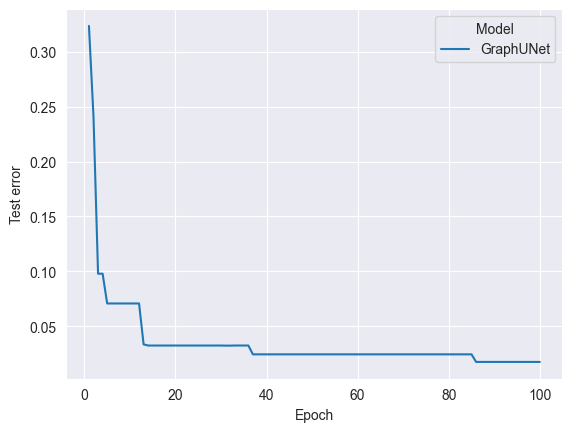

In [63]:
#for i in range(2,3):
p = sns.lineplot(x="Epoch", y=f"Test error", hue="Model", data=DF_RESULTS)
plt.show()

In [58]:
graph_output_list = []

# Process each data element and store the output
for data in unet_out_list[:100]:
    data = data.to(device)
    with torch.no_grad():
        output = model(data)[0]
    graph_output_list.append(output.cpu())

In [59]:
def extract_tuples(pressed_keys):
    extracted_data_tuples = []
    prev_indices = []
    for i in range(len(pressed_keys)):
        pressed_keys[i] = pressed_keys[i].squeeze()
        timestep = pressed_keys[i][0].item()
        indices = torch.where(pressed_keys[i][1:] > 1/100)[0].squeeze()
        if indices.numel() == 1:
            indices = [indices.add(1).tolist()]
        else:
            indices = indices.add(1).tolist()

        # indices = torch.nonzero(pressed_keys[i][1:] > 1e-2).squeeze(-1).tolist()
        extracted_data_tuples.append((0, 0, timestep))
        for x in indices:
            if x not in prev_indices:
                if BINARY_VELOCITY and pressed_keys[i][x] < 0.5:
                    continue
                velocity = 64 if BINARY_VELOCITY else round(pressed_keys[i][x].item() * 128)
                extracted_data_tuples.append((x, velocity, 0))
        for x in prev_indices:
            if x not in indices:
                extracted_data_tuples.append((x, 0, 0))
    return extracted_data_tuples
extrated_tuples = extract_tuples(graph_output_list)

In [61]:
def tuples_to_midi(tuples, filename, timestep_std):
    # Initialize a new MIDI file and track
    midi_file = MidiFile()
    track = MidiTrack()
    midi_file.tracks.append(track)

    # Process tuples and add MIDI messages to the track
    for note, velocity, timestep in tuples:
        # De-normalize velocity and timestep
        # velocity = round(velocity * velocity_std)
        timestep = round(timestep * timestep_std)

        # Adjust note range
        note = note + 20

        # Clamp values to the valid MIDI range
        note = max(21, min(108, note))
        velocity = velocity * 10
        velocity = max(0, min(127, velocity))
        if BINARY_VELOCITY:
            velocity = 64
        # Add MIDI messages to the track
        track.append(Message('note_on', note=note, velocity=velocity, time=timestep))

    # Save the MIDI file
    midi_file.save(filename)
tuples_to_midi(extrated_tuples, 'unet_output.mid', timestep_std)